# Reservoir model - no full backpropagation

- Using an echo state network, see summary for details. 
- Performing classification on the Digits dataset from sklearn.
- Results measured in logg loss (sum) and accuracy. 

Questions i still have / feedback.
- I very explicitly implemented the model as how it is stated on the planner. 
    - Still figuring if using Linear Layers (though, with recurrent input) is the correct way of implementation.
- Comparing the RNN (2 layers with softmax activation)and the Recurrent reservoir, the sum loss seems way lower with the reservoir model. How is that possible. Is that because the weights are differently initialized? 
- It seems that the bias parameters are still trained, is this desirable?
- Maybe for the baseline -> use this model instead? With all parameters requires_grad = True ?
- The addition in C_T -> is this concatenate the two matrix? or actually add them together 
- Using mini batch gradient descent turned out to work better (just an observation) 
- What parameters should be kept ? (learning rate, momentum sgd, batch size ) 


In [69]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary

### The Digits Dataset:

In [70]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [71]:
# Initiliazing the data loaders for the digits dataset. 

train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

LABELS = train_data.target_names

train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

result_dir = 'results_reservoir_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

6


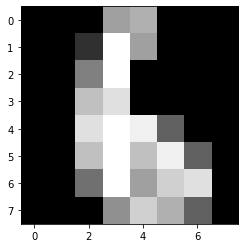

In [72]:
# Print an example digit and its according target label. - (digits dataset)

print(train_data.targets[88])
plottable_image = np.reshape(train_data.data[88], (8, 8))
plt.imshow(plottable_image, cmap='gray')

In [73]:
class Reservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size):
        super(Reservoir, self).__init__()
        self.f_0 = nn.Softmax(dim=1)
        self.f_t = nn.Softmax(dim=1)
        self.f_y = nn.Softmax(dim=1)
        
        # Sample the initial weights from a uniform distribution
        self.W_in = nn.Parameter(data = torch.zeros(reservoir_size, input_size, requires_grad=False))
        self.W_in.data.uniform_(-1, 1)
        
        self.W_r = nn.Parameter(data = torch.zeros(reservoir_size, reservoir_size), requires_grad=False)
        self.W_r.data.uniform_(-1, 1)
        
        self.W_out = nn.Parameter(data = torch.zeros(output_size, reservoir_size), requires_grad=True)
        self.W_out.data.uniform_(-1, 1)
        
        self.U = nn.Parameter(data = torch.zeros(reservoir_size, input_size), requires_grad=False)
        self.U.data.uniform_(-1, 1)
        
        # Layer only used for C_0, initial weight!
        self.layer1 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer1.weight = self.W_in
        #Making sure we do not calc the gradient of our input layer! only for output. 
        self.layer1.weight.requires_grad = False
        
        self.layer2 = torch.nn.Linear(reservoir_size, reservoir_size, bias=True)
        self.layer2.weight = self.W_r
        
        self.layer3 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer3.weight = self.U
        
        self.layer4 = torch.nn.Linear(2*reservoir_size, output_size, bias=True)
        self.layer4.weight = self.W_out
        

    def forward(self, input_state, t, prev_c):
        
        # Prev_c = c at t - 1
        
        # If we have the first batch, calculate c_0 = f_0(W_in * x_t)
        if t == 1:
            prev_c = self.init_C(input_state)
        
        # Not the first batch? -> use output from previous state!
        # W_r * c_t_1
        output_lin_2 = self.layer2(prev_c)
        
        # U * x_t
        output_lin_3 = self.layer3(input_state)
        
        # Calculate new c_t -  f_t (W_r * c_t-1 + U * x_t)
        c_t = self.f_t(output_lin_2 + output_lin_3)
        
        # Calculate output - f_y ( W_out * c_t)
        y = self.f_y(self.layer4(c_t))
    
        return y, c_t
    
    def init_C(self, input_state):
        output_linear_layer1 = self.layer1(input_state)
        c_0 = self.f_0(output_linear_layer1)
        return c_0
    

In [74]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]

# Plot both accuracy as log loss. 
def plot_results(epochs, loss, accuracy):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Results Reservoir - Only output is trained.')
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    ax1.plot(epochs, loss)
    ax2.plot(epochs, accuracy)
    

    plt.savefig('results_reservoir.png', bbox_inches='tight')
    #plt.close()


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initialize counters / c
    loss = 0.
    N = 0.
    prev_c = 0
    t = 1
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        output, new_c = model.forward(batch, t, prev_c)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        prev_c = new_c
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [75]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):    
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0

    t = 1
    prev_c = 0

    for epoch in range(num_epochs):

        # Training
        model.train()
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output, new_c = model.forward(batch, t, prev_c)

            targets = targets.long()
            prev_c =  new_c

            t += 1
            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
        # Perform back prop after each epoch
        loss = loss_function(output, targets)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()

        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)

        if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_reservoir.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_reservoir.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1

            # If loss has not improved for an arbitrary amount of epochs:
        if loss_iter > max_loss_iter:
            break

    plot_results(epochs, loss_results, accuracy_results)

    return model

    

In [76]:
input_size = 64
reservoir_size = 128
n_labels = 10
lr_SGD =  0.5
momentum_SGD = 0.9
n_epochs = 5
max_loss_iter = 10
batch_size=50

model = Reservoir(input_size, reservoir_size, n_labels)
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='mean') # Mean is also possible.


In [77]:
# Check all parameters that are trained: should only be W_out!
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

W_out
layer1.bias
layer2.bias
layer3.bias
layer4.bias


Training started for 5 epochs.
Epoch: 0 - Loss of: -0.0019938265212944574 - Accuracy of: 6.285714149475098
* Saving 1st epoch model *
Epoch: 1 - Loss of: -0.0019979006903512136 - Accuracy of: 6.5714287757873535
* Saving new best model *
Epoch: 2 - Loss of: -0.0020029141221727643 - Accuracy of: 7.714285850524902
* Saving new best model *
Epoch: 3 - Loss of: -0.0020107017031737737 - Accuracy of: 8.0
* Saving new best model *
Epoch: 4 - Loss of: -0.002018922311919076 - Accuracy of: 8.0
* Saving new best model *


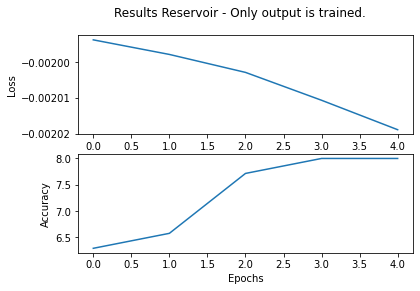

In [78]:
trained_model = training(model, train_loader, val_loader, n_epochs, optimizer, loss_function, max_loss_iter)

In [79]:
# Prev_c input is required, but not used in T = 1
prev_c = 0
print(summary(model, torch.zeros(1, 64), 1, prev_c, show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1             [1, 64]           8,320             128
         Softmax-2            [1, 128]               0               0
          Linear-3            [1, 128]          16,512             128
          Linear-4             [1, 64]           8,320             128
         Softmax-5            [1, 128]               0               0
          Linear-6            [1, 128]           1,290           1,290
         Softmax-7             [1, 10]               0               0
Total params: 34,442
Trainable params: 1,674
Non-trainable params: 32,768
-----------------------------------------------------------------------


In [80]:
test_result = evaluation(test_loader, trained_model, 'Final score', loss_function)

Epoch: Final score - Loss of: -0.0019054060481005334 - Accuracy of: 6.26398229598999
